In [15]:
#if (!require("BiocManager", quietly = TRUE))
    #install.packages("BiocManager")

#BiocManager::install("DESeq2")


#if (!require("BiocManager", quietly = TRUE))
    #install.packages("BiocManager")

#BiocManager::install("GEOquery")

#if (!require("BiocManager", quietly = TRUE))
    #install.packages("BiocManager")

#BiocManager::install("limma")



In [16]:
#   Differential expression analysis with DESeq2
library(DESeq2)


# load counts table from GEO
urld <- "https://www.ncbi.nlm.nih.gov/geo/download/?format=file&type=rnaseq_counts"
path <- paste(urld, "acc=GSE182401", "file=GSE182401_raw_counts_GRCh38.p13_NCBI.tsv.gz", sep="&");
tbl <- as.matrix(data.table::fread(path, header=T, colClasses="integer"), rownames="GeneID")

# load gene annotations 
apath <- paste(urld, "type=rnaseq_counts", "file=Human.GRCh38.p13.annot.tsv.gz", sep="&")
annot <- data.table::fread(apath, header=T, quote="", stringsAsFactors=F, data.table=F)
rownames(annot) <- annot$GeneID

# sample selection
gsms <- "0011111"
sml <- strsplit(gsms, split="")[[1]]

# group membership for samples
gs <- factor(sml)
groups <- make.names(c("CONTROL","MCL1 INHIBITOR"))
levels(gs) <- groups
sample_info <- data.frame(Group = gs, row.names = colnames(tbl))

# pre-filter low count genes
# keep genes with at least N counts > 10, where N = size of smallest group
keep <- rowSums( tbl >= 10 ) >= min(table(gs))
tbl <- tbl[keep, ]




estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



"GeneID"	"padj"	"pvalue"	"lfcSE"	"stat"	"log2FoldChange"	"baseMean"	"Symbol"	"Description"
6004	0	0	0.119827925222635	40.3656394369186	4.83693082401091	3823.10175039661	"RGS16"	"regulator of G protein signaling 16"
10602	0	0	0.149990053698026	37.6102835240371	5.64116844536831	3617.48900660731	"CDC42EP3"	"CDC42 effector protein 3"
822	0	0	0.209391198954731	46.5810907597162	9.7536704427961	5122.6526085616	"CAPG"	"capping actin protein, gelsolin like"
3815	0	0	0.206076501455989	-48.4899526992483	-9.99263980802746	78999.8826918823	"KIT"	"KIT proto-oncogene, receptor tyrosine kinase"
972	0	0	0.15992875832294	38.3373914160721	6.13125140651295	5844.68492435284	"CD74"	"CD74 molecule"
79930	0	0	0.143264108531475	-39.3368182612414	-5.63555420066139	9363.59554928176	"DOK3"	"docking protein 3"
105377845	0	0	0.15664492817564	-38.4135936317316	-6.01729461541083	12718.4163591502	"LOC105377845"	"uncharacterized LOC105377845"
6770	0	0	0.157137007278456	43.9655121122688	6.90860899678662	2580.26705276794

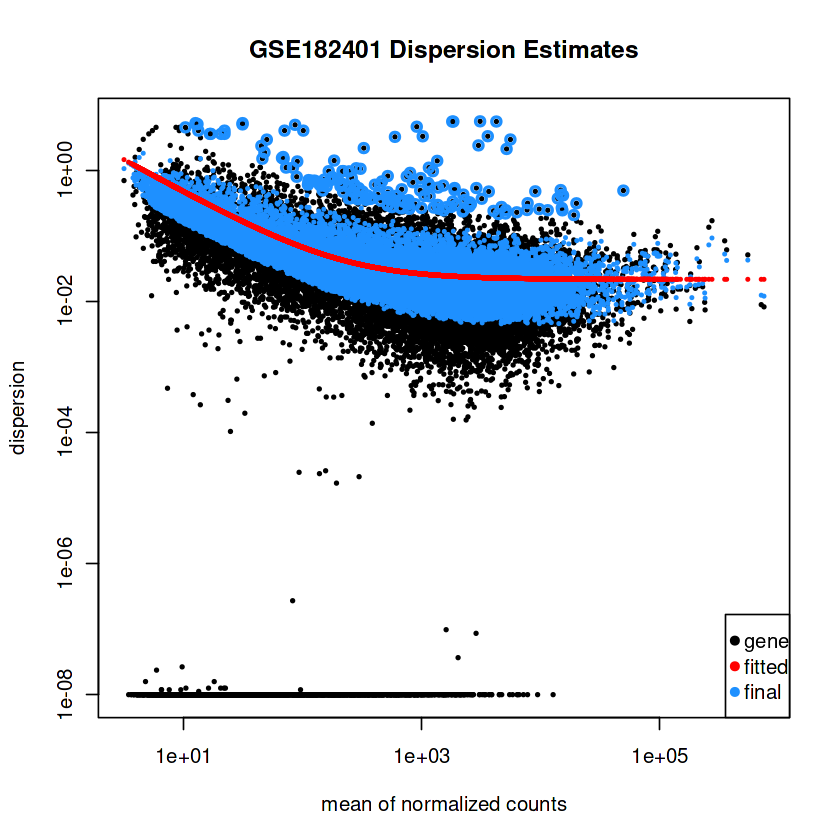

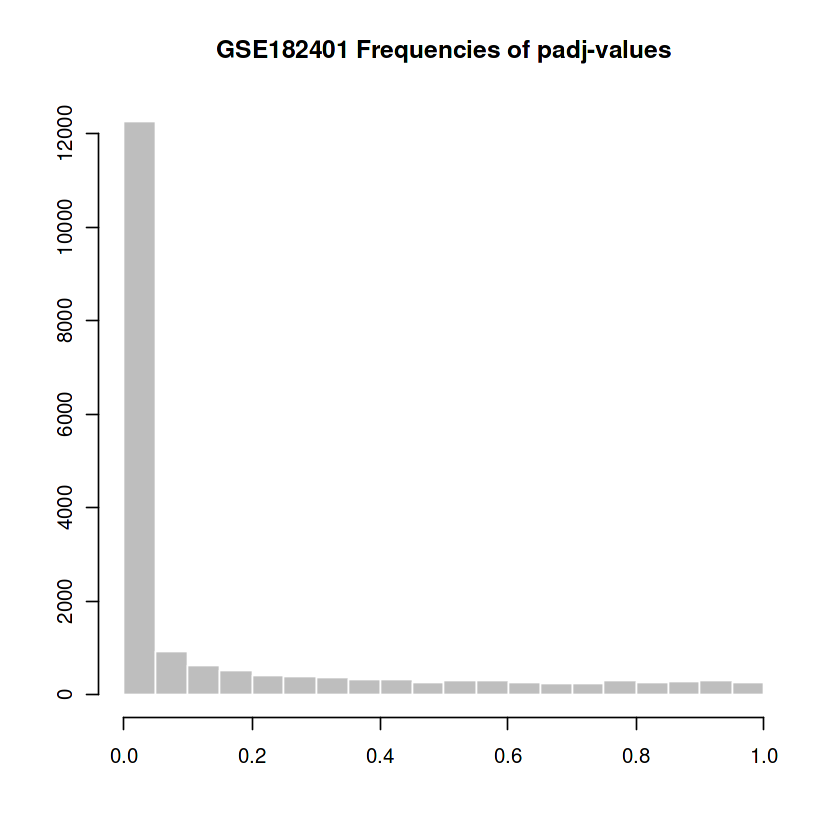

In [17]:
#Run Deseq2

ds <- DESeqDataSetFromMatrix(countData=tbl, colData=sample_info, design= ~Group)

ds <- DESeq(ds, test="Wald", sfType="poscount")

# extract results for top genes table
r <- results (ds, contrast=c("Group", groups[1], groups[2]), alpha=0.05, pAdjustMethod ="fdr")

tT <- r[order(r$padj)[1:250],] 
tT <- merge(as.data.frame(tT), annot, by=0, sort=F)

tT <- subset(tT, select=c("GeneID","padj","pvalue","lfcSE","stat","log2FoldChange","baseMean","Symbol","Description"))
write.table(tT, file=stdout(), row.names=F, sep="\t")

plotDispEsts(ds, main="GSE182401 Dispersion Estimates")

# create histogram plot of p-values
hist(r$padj, breaks=seq(0, 1, length = 21), col = "grey", border = "white", 
         xlab = "", ylab = "", main = "GSE182401 Frequencies of padj-values")





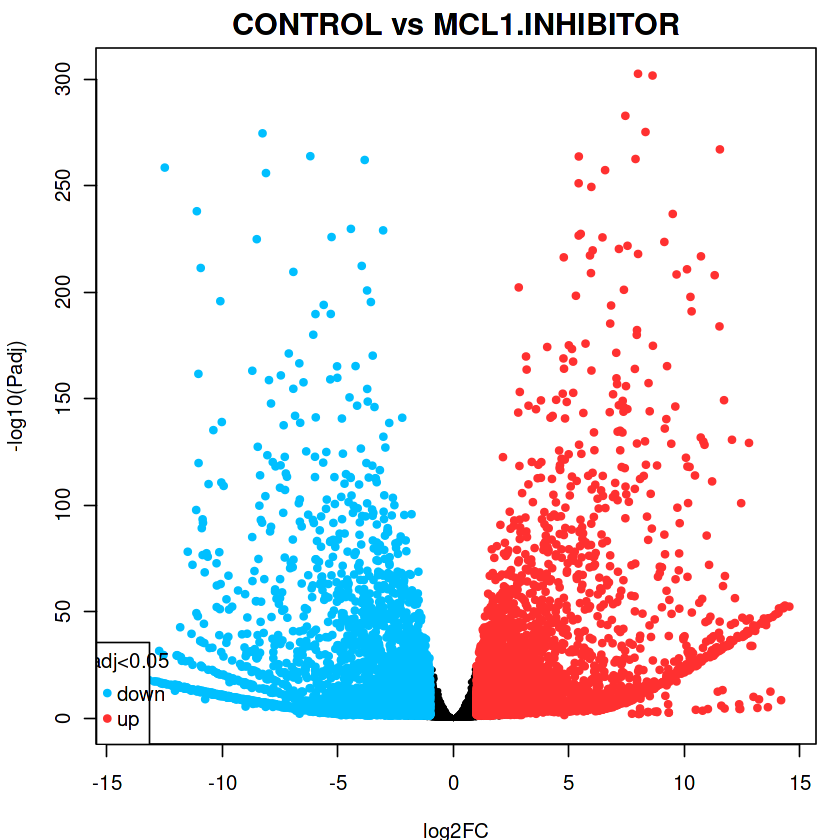

In [18]:
# volcano plot
old.pal <- palette(c("#00BFFF", "#FF3030")) # low-hi colors
par(mar=c(4,4,2,1), cex.main=1.5)
plot(r$log2FoldChange, -log10(r$padj), main=paste(groups[1], "vs", groups[2]),
     xlab="log2FC", ylab="-log10(Padj)", pch=20, cex=0.5)
with(subset(r, padj<0.05 & abs(log2FoldChange) >= 1),
     points(log2FoldChange, -log10(padj), pch=20, col=(sign(log2FoldChange) + 3)/2, cex=1))
legend("bottomleft", title=paste("Padj<", 0.05, sep=""), legend=c("down", "up"), pch=20,col=1:2)



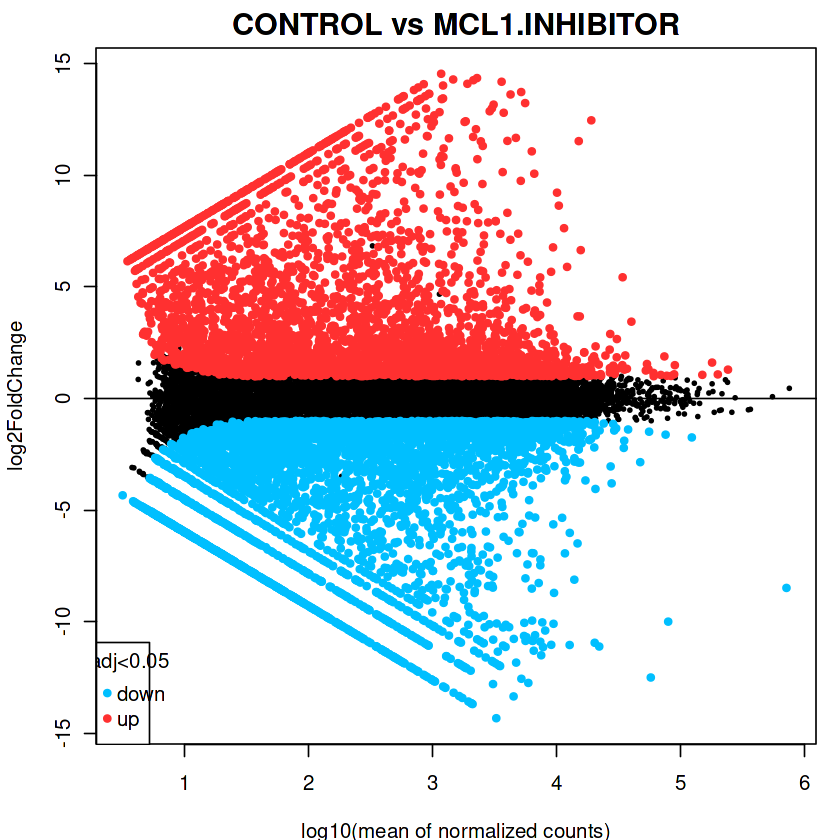

In [19]:
# MD plot
par(mar=c(4,4,2,1), cex.main=1.5)
plot(log10(r$baseMean), r$log2FoldChange, main=paste(groups[1], "vs", groups[2]),
     xlab="log10(mean of normalized counts)", ylab="log2FoldChange", pch=20, cex=0.5)
with(subset(r, padj<0.05 & abs(log2FoldChange) >= 1),
     points(log10(baseMean), log2FoldChange, pch=20, col=(sign(log2FoldChange) + 3)/2, cex=1))
legend("bottomleft", title=paste("Padj<", 0.05, sep=""), legend=c("down", "up"), pch=20,col=1:2)
abline(h=0)
palette(old.pal) # restore palette



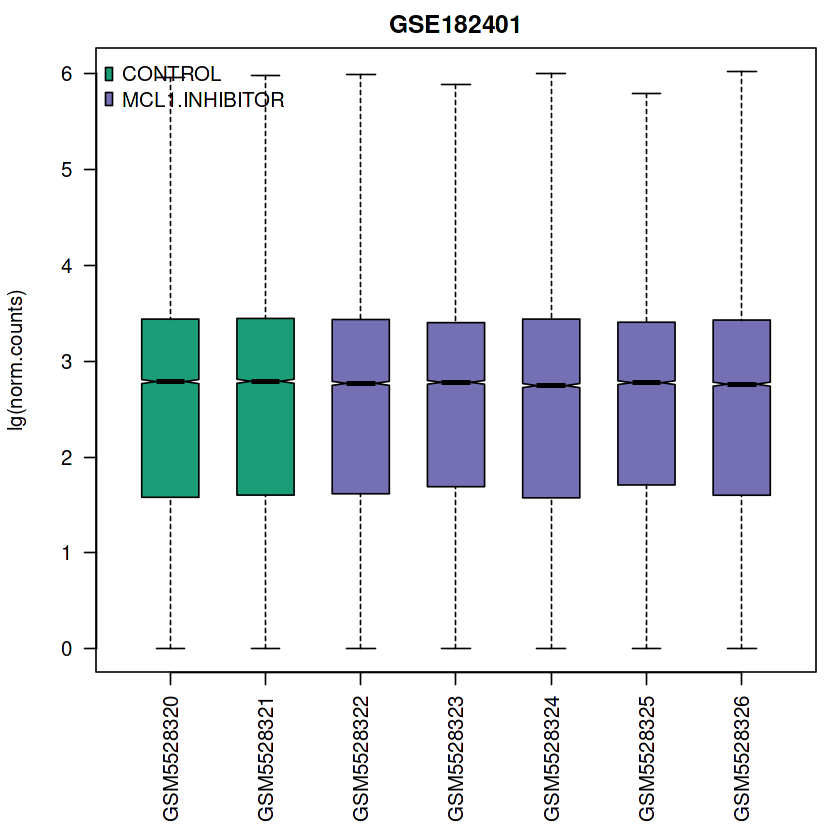

In [20]:
################################################################
#   General expression data visualization
dat <- log10(counts(ds, normalized = T) + 1) # extract normalized counts

# box-and-whisker plot
lbl <- "log10(raw counts + 1)"
ord <- order(gs)  # order samples by group
palette(c("#1B9E77", "#7570B3", "#E7298A", "#E6AB02", "#D95F02",
          "#66A61E", "#A6761D", "#B32424", "#B324B3", "#666666"))
par(mar=c(7,4,2,1))
boxplot(dat[,ord], boxwex=0.6, notch=T, main="GSE182401", ylab="lg(norm.counts)", outline=F, las=2, col=gs[ord])
legend("topleft", groups, fill=palette(), bty="n")



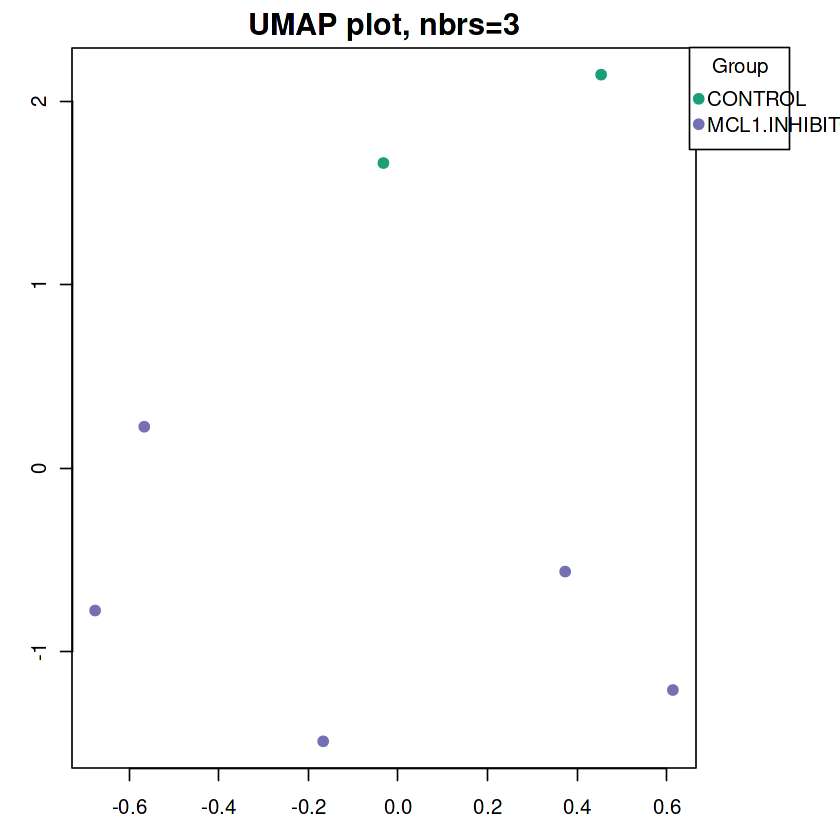

In [21]:
# UMAP plot (multi-dimensional scaling)
library(umap)
dat <- dat[!duplicated(dat), ] # first remove duplicates
par(mar=c(3,3,2,6), xpd=TRUE, cex.main=1.5)
ump <- umap(t(dat), n_neighbors = 3, random_state = 123)
plot(ump$layout, main="UMAP plot, nbrs=3", xlab="", ylab="", col=gs, pch=20, cex=1.5)
legend("topright", inset=c(-0.15,0), legend=groups, pch=20,
       col=1:length(groups), title="Group", pt.cex=1.5)